### QRS波群检测
1. R波峰值点定位
   - 幅度法（高大T波容易出错）
   - 面积法（高大T波容易出错）
   - 斜率法（差分阈值法）：将滤波之后的高信噪比电信号进行差分计算，然后采用预先给定的阈值进行判别
  
2. QRS波群宽度检测
   - 阈值法：心电信号通过特定的数字滤波器进行滤波处理，使得QRS波群到来时输出一个脉冲信号，脉冲幅度反映了QRS波群幅度和频率的综合特征信息。将输出的脉冲幅度与阈值比较，就能确定宽度参数
     - Tompkins差分法
     - 正交滤波法

差分阈值法：R波在上升或下降波形的斜率变化最大，其中一阶导数过零点或者二阶导数的极值点位置即是R波的位置，微分和平方过程用于突出QRS波群特征，移动窗积分用于QRS波群宽度测量。阈值大小随着信号不断调整，从而提高检测的可靠性。回检过程中采用双阈值，提高了检测精度，特别防止噪声引起的假阳性。
- 经过模数转换器，再通过简单整系数滤波器，滤除频率范围为0-0.7Hz的呼吸基线漂移
- 通过带阻滤波器，用于滤除频率为50Hz的工频干扰
- 通过低通滤波器，用于滤除100Hz以上的肌颤高频噪声

截止频率是描述滤波器性能的一个指标。对于一个滤波器，在其输入信号幅度保持不变的情况下，只改变输入信号的频率，当其输出信号幅度下降为输入信号幅度的0.707倍时，此时的频率即为该滤波器的截止频率。

低通滤波器：输入信号频率的升高，其输出信号幅度越来越小，所以高频信号难以通过该电路。

输出信号
$$
U_0 = U_i * \frac{j \frac{1}{WC}}{R + j \frac{1}{WC}} = \frac{1}{\sqrt{1 + W^2 C^2 R^2}} U_i
$$
当输出信号幅度下降为输入信号的0.707倍时:
$$
\frac{1}{\sqrt{1 + W^2 C^2 R^2}} = \frac{1}{\sqrt{2}}
$$
可以得出其截止频率为：
$$
f = \frac{W}{2 \pi} = \frac{1}{2 \pi R C}
$$
此时输出信号的功率下降为输入信号功率的一半。

0.08613019954354689


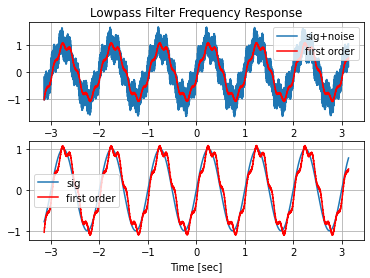

In [1]:
# 低通滤波器实现
import numpy as np
import matplotlib.pyplot as plt
 
Ts=0.003                     #采样时间
Fl=5                        #截止频率
a=1/(1+1/(2*np.pi*Ts*Fl))    #滤波系数
 
print(a)                         #打印滤波计算出的值
x=np.linspace(-np.pi,np.pi,2000) #在[-pi,pi]区间上分割正2000个点
                                 # 可以理解为信号采样时间为 2*pi/2000s
data1=np.zeros_like(x)           #输入信号
data=np.zeros_like(x)            #输入信号
y1=np.zeros_like(x)              #一阶滤波输出
for i in range(len(x)):
    #幅值为1 频率为 1Hz的信号  + 幅值为0.5 频率为100Hz的干扰信号+ 幅值为0.2 频率为6Hz的干扰信号
    data =np.sin( 2 * np.pi * x)+0.2*np.sin(6* 2 * np.pi * x)\
             +0.5*np.sin(100* 2 * np.pi * x)
    data1[i]=np.sin( 2 * np.pi * x[i])
    if(i>0):
        y1[i] = a * data[i] + (1 - a) * y1[i - 1]
    else:
        y1[0] = data[0]


#绘制被干扰的信号  + 一阶滤波后的信号
 
plt.subplot(2, 1, 1)
plt.plot(x,data ,label='sig+noise')
plt.plot(x,y1,   'r',label='first order')
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()
#原信号  + 一阶滤波后的信号
plt.subplot(2, 1, 2)
plt.plot(x,data1 ,label='sig')
plt.plot(x,y1,   'r',label='first order')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.show()

In [2]:
def fL(t, a):
    """
    当目标参数为变化很慢的物理量时很有效
    不能滤除高于1/2采样频率的干扰信号 i.e. 对(1/2 * 1/t) Hz以上的干扰信号应用其他方式滤除
    Returns
    滤波算法的截止频率
    ------
    Params
    t: 采样间隔时间
    a: 滤波系数
    """
    return a / (2 * np.pi * t)

print (f'滤波算法的截止频率 = {fL(t=0.5, a=1/32)} Hz')

滤波算法的截止频率 = 0.009947183943243459 Hz


滑动窗口平均滤波法（对周期性干扰有良好的抑制作用，平滑度高，适用于高频震荡的系统）
1. 设置递推平均滤波的窗口大小$N$，较大的窗口对噪声有更好的抑制作用，但会导致滤波后数据出现滞后的现象，影响系统灵敏性
2. 计算当前时刻采样数据与前$N-1$个采样点数据的均值作为当前时刻的采样值
3. 将窗口向前滑动一个步长，采样到新数据放到队尾，扔掉队首采样值，重复步骤2

例子：
- 原始数据：$x_0, x_1, x_2, x_3, x_4, x_5$
- 窗口滑动：$x_0, \frac{x_0+x_1}{2}, \frac{x_0+x_1}{2}, \frac{x_0+x_1}{2}, \frac{x_0+x_1}{2}$ ($N=2$)
- 窗口滑动：$x_0, x_1, \frac{x_0+x_1+x_2}{3}, \frac{x_1+x_2+x_3}{3}, \frac{x_2+x_3+x_4}{3}, \frac{x_3+x_4+x_5}{3}$ ($N=3$)

平均值滤波法

高级：fir

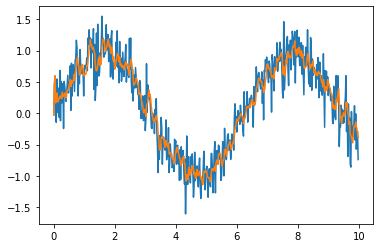

In [3]:
t = np.arange(0, 10, 0.02)
x = np.sin(t) + 0.25 * np.random.randn(len(t))
window_size = 5

def sliding_window_filtering(x, window_size):
    y = np.zeros_like(x)
    s = 0
    for i in range(len(x)):
        if (i+1) < window_size:
            s += x[i]
            y[i] = x[i]
        elif (i+1) == window_size:
            s += x[i]
            y[i] = s / window_size
        else:
            head = x[i-window_size]
            s -= head
            s += x[i]
            y[i] = s / window_size
    return y

plt.plot(t, x, label='orginal')
plt.plot(t, sliding_window_filtering(x=x, window_size=window_size), label='smoothing')

## 数字滤波
- 巴特沃斯带通滤波器[4]，考虑了ECG的频谱特性分布（Tanker）
- 自适应滤波方法[5]，跟随工频信号的频率幅度变化而自动调节并抵消工频干扰（Fei）
- 自适应线性滤波器，进一步提高信噪比（Tanker）
- 非线性滤波器[6]，解决干扰与信号频谱混叠（Yu）
- 基于神经网络的非线性自适应滤波器[7]，消除了基线漂移、伪差的影响（Xue）
- 自适应滤波器采用的模版都要受QRS波形变异的影响

## 滤波后的信号经过某种变换（提高QRS波信号的分量）-检测（阈值判别）
- 一阶二阶差分检测QRS波[8]（Ahlstrom）
- 可变阈值检测法：幅度阈值、斜率阈值、时间间隔阈值[9,10]

### 心电信号的预处理
- 消除50Hz基波和谐波的工频干扰
  - 平滑滤波器、或固定频率的窄带陷波器
  - 自适应滤波（需要工频干扰的参考输入信号）

### 平滑滤波器要求原始心电信号满足的两个条件
- 采样频率$f_s$是工频干扰的整数倍
- 在一个工频干扰周期内，工频干扰采样点的幅值的代数和为零
当$f_s = 500Hz$，其传递函数为
$$
H(z) = \frac{1}{10} (1 + z^{-1} + z^{-2} + \cdots + z^{-9})
$$
差分方程为
$$
y(n) = \frac{1}{10} [x(n) + x(n-1) + \cdots + x(n-9)]
$$
其中$x(n-i)$为带有干扰的原始输入，即心电信号与工频噪声之和，$y(n)$为滤波后的心电信号

### QRS波检测方法[60-62]
